<a href="https://colab.research.google.com/github/AfricaMachineIntelligence/OpenGesture/blob/main/OpenVINO_%2B_OpenCV_OAK_Tensorflow_Gesture_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [ ]:
import pathlib
dataset_url = "https://planetg.s3.amazonaws.com/opengesture-data.tar.xz"
data_dir = tf.keras.utils.get_file('opengesture-data', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

379568128/379565684 [==============================] - 8s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2662 files belonging to 10 classes.
Using 2130 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2662 files belonging to 10 classes.
Using 532 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['eight', 'five', 'four', 'nine', 'one', 'seven', 'six', 'three', 'two', 'zero']


## Visualize the data

Here are the first 9 images from the training dataset.

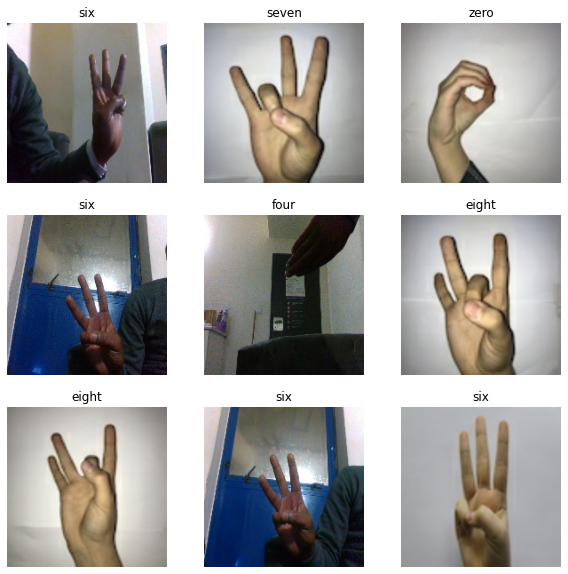

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.027452804 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [ ]:
num_classes = 10

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)       

## Train the model

In [ ]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
67/67 [==============================] - 2s 23ms/step - loss: 0.1185 - accuracy: 0.9629 - val_loss: 0.3535 - val_accuracy: 0.9041
Epoch 2/100
67/67 [==============================] - 1s 22ms/step - loss: 0.1305 - accuracy: 0.9554 - val_loss: 0.4170 - val_accuracy: 0.8985
Epoch 3/100
67/67 [==============================] - 1s 22ms/step - loss: 0.1261 - accuracy: 0.9545 - val_loss: 0.5792 - val_accuracy: 0.8872
Epoch 4/100
67/67 [==============================] - 1s 22ms/step - loss: 0.1315 - accuracy: 0.9573 - val_loss: 0.4640 - val_accuracy: 0.9023
Epoch 5/100
67/67 [==============================] - 1s 22ms/step - loss: 0.1385 - accuracy: 0.9568 - val_loss: 0.4054 - val_accuracy: 0.9023
Epoch 6/100
67/67 [==============================] - 1s 22ms/step - loss: 0.1293 - accuracy: 0.9559 - val_loss: 0.4281 - val_accuracy: 0.9023
Epoch 7/100
67/67 [==============================] - 1s 22ms/step - loss: 0.1195 - accuracy: 0.9620 - val_loss: 0.3906 - val_accuracy: 0.9004
Epoch 

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

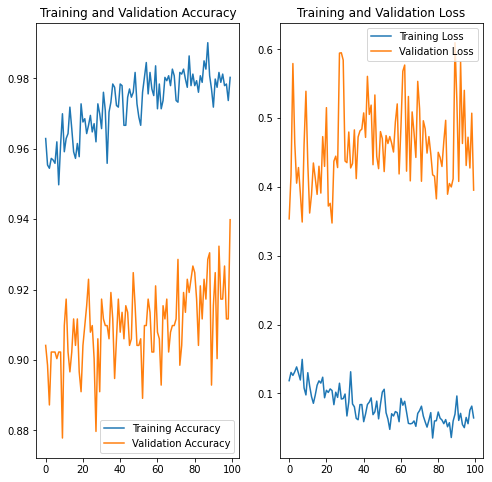

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

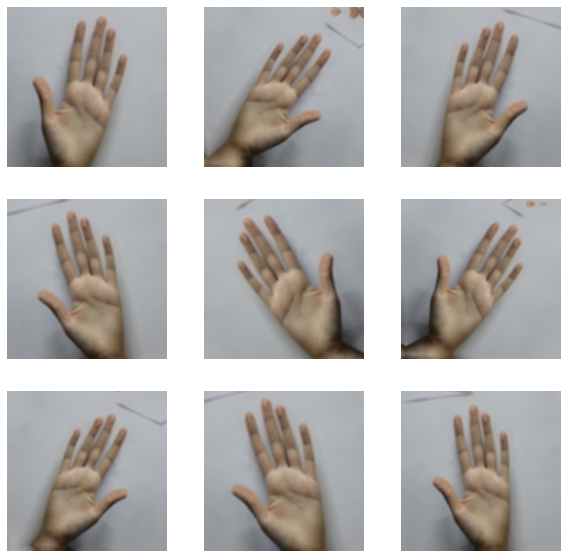

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
67/67 [==============================] - 2s 25ms/step - loss: 2.3292 - accuracy: 0.1070 - val_loss: 2.2579 - val_accuracy: 0.1090
Epoch 2/100
67/67 [==============================] - 1s 22ms/step - loss: 2.2243 - accuracy: 0.1568 - val_loss: 2.1431 - val_accuracy: 0.2368
Epoch 3/100
67/67 [==============================] - 1s 21ms/step - loss: 1.9619 - accuracy: 0.2808 - val_loss: 1.6073 - val_accuracy: 0.4060
Epoch 4/100
67/67 [==============================] - 1s 22ms/step - loss: 1.6207 - accuracy: 0.4343 - val_loss: 1.3080 - val_accuracy: 0.5508
Epoch 5/100
67/67 [==============================] - 1s 22ms/step - loss: 1.3729 - accuracy: 0.5103 - val_loss: 1.2104 - val_accuracy: 0.5940
Epoch 6/100
67/67 [==============================] - 1s 22ms/step - loss: 1.1678 - accuracy: 0.6047 - val_loss: 0.9118 - val_accuracy: 0.6936
Epoch 7/100
67/67 [==============================] - 1s 22ms/step - loss: 1.0111 - accuracy: 0.6446 - val_loss: 0.8628 - val_accuracy: 0.6955
Epoch 

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

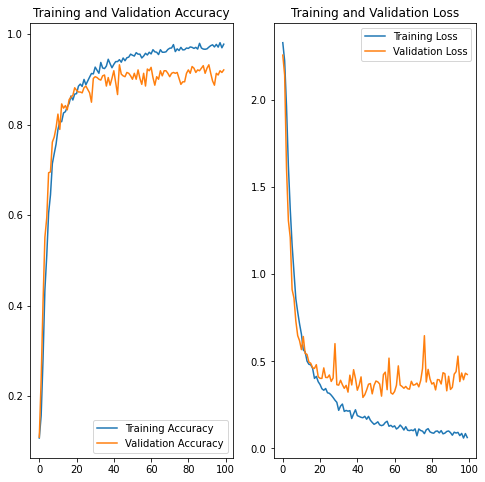

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [ ]:
sunflower_url = "https://planetg.s3.amazonaws.com/7a_Color.png"
sunflower_path = tf.keras.utils.get_file('7a_Color', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to seven with a 99.98 percent confidence.


In [ ]:
#from google.colab import files
model_fname="gesture"
model.save(model_fname)
#!zip -r /tmp/flower.zip /tmp/flower
#files.download('/tmp/flower.zip')

INFO:tensorflow:Assets written to: gesture/assets




```
# This is formatted as code
```

# Intel OpenVINO toolkit Installation and Validations

In [ ]:
print("This will take a while...")
!wget -O openvino_key https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021?elq_cid=6770273_ts1607381885691&erpm_id=9830841_ts1607381885691&elq_cid=6770273_ts1607381960247&erpm_id=9830841_ts1607381960247 
!apt-key add openvino_key
#!apt-key -q list
!echo "deb https://apt.repos.intel.com/openvino/2021 all main" | tee /etc/apt/sources.list.d/intel-openvino-2021.list
!apt update -q
!apt-cache search intel-openvino-dev-ubuntu18
!apt-get install intel-openvino-dev-ubuntu18-2021.2.200 -y -q
!pip install -U --no-deps --quiet openvino

#unknown bug - this is just a patch
!cp /opt/intel/openvino_2021/deployment_tools/inference_engine/external/tbb/lib/libtbb.so /usr/lib/x86_64-linux-gnu/libtbb.so
!cp /opt/intel/openvino_2021/deployment_tools/inference_engine/external/tbb/lib/libtbb.so.2 /usr/lib/x86_64-linux-gnu/libtbb.so.2
!ldconfig
print("Installation Completed...")
#%env we can set environmental variable with this

#Run the validation
!ls /opt/intel/
#Run the Validation Demo code.
demo_cmd = "/opt/intel/openvino_2021/deployment_tools/demo/demo_squeezenet_download_convert_run.sh"
import os
import subprocess
import shutil
output = subprocess.check_output(demo_cmd, shell=True)
print (output.decode('utf-8'))     

This will take a while...
--2021-08-06 22:39:05--  https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021?elq_cid=6770273_ts1607381885691
Resolving apt.repos.intel.com (apt.repos.intel.com)... 104.105.115.4, 2600:1406:3f:a90::4b23, 2600:1406:3f:a95::4b23
Connecting to apt.repos.intel.com (apt.repos.intel.com)|104.105.115.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 939 [binary/octet-stream]
Saving to: ‘openvino_key’

openvino_key        100%[===================>]     939  --.-KB/s    in 0s      

2021-08-06 22:39:06 (147 MB/s) - ‘openvino_key’ saved [939/939]

OK
deb https://apt.repos.intel.com/openvino/2021 all main
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:4 https://developer.downloa

## Convert to OpenVINO IR format

In [ ]:
source_cmd= "/opt/intel/openvino_2021/bin/setupvars.sh"

# Setup model optimizer command ...
ir_name = "gesture"
ir_data_type = "FP32"
ir_out_dir = f"{model_fname}/IR_models/{ir_data_type}"
ir_input_shape = "[1,180,180,3]"
mo_cmd = f"/opt/intel/openvino_2021/deployment_tools/model_optimizer/mo_tf.py \
      --saved_model_dir {model_fname} \
      --input_shape {ir_input_shape} \
      --data_type {ir_data_type} \
      --output_dir {ir_out_dir}  \
      --model_name {ir_name}"
print ("Running model optimizer to convert model to OpenVINO IR format ....")
print("\n--".join(mo_cmd.split("--")))

output = subprocess.check_output(source_cmd+" && "+mo_cmd, shell=True)
print (output.decode('utf-8'))     

Running model optimizer to convert model to OpenVINO IR format ....
/opt/intel/openvino_2021/deployment_tools/model_optimizer/mo_tf.py       
--saved_model_dir gesture       
--input_shape [1,180,180,3]       
--data_type FP32       
--output_dir gesture/IR_models/FP32        
--model_name gesture
[setupvars.sh] OpenVINO environment initialized
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/content/gesture/IR_models/FP32
	- IR output name: 	gesture
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,180,180,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels:

## Validate the OpenVINO IR

In [ ]:
#install pre-req
!pip install pillow numpy -q

from PIL import Image
import numpy as np

def pre_process_image(imagePath, img_height=180):
    # Model input format
    n, c, h, w = [1, 3, img_height, img_height]
    image = Image.open(imagePath)
    image = image.resize((h, w), resample=Image.BILINEAR)

    # Normalize to keep data between 0 - 1
    image = np.array(image) 

    # Change data layout from HWC to CHW
    image = image.transpose((2, 0, 1))
    input_image = image.reshape((n, c, h, w))

    return input_image

Run the inference

In [ ]:
from openvino.inference_engine import IECore

model_xml = f'{ir_out_dir}/{ir_name}.xml'
model_bin = f'{ir_out_dir}/{ir_name}.bin'

# Load network to the plugin
ie = IECore()
net = ie.read_network(model=model_xml, weights=model_bin)
exec_net = ie.load_network(network=net, device_name="CPU")
del net

input_layer = next(iter(exec_net.input_info))
output_layer = next(iter(exec_net.outputs))

# Run the Inference on the Input image...
inp_img_url = "https://planetg.s3.amazonaws.com/7a_Color.png"
inp_file_name = '7a_Color.png'

#Download the image from the storage
output = subprocess.check_output(f"curl {inp_img_url} --output {inp_file_name}", shell=True)

#Pre-process the image and get it ready for inference.
input_image = pre_process_image(inp_file_name)

res = exec_net.infer(inputs={input_layer: input_image})
res = res[output_layer]

score = tf.nn.softmax(res[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to seven with a 99.98 percent confidence.


## Convert OpenVINO IR to Blob format 

In [ ]:
!cp /opt/intel/openvino_2021.2.200/deployment_tools/inference_engine/lib/intel64/libmyriadPlugin.so /usr/lib/x86_64-linux-gnu/libmyriadPlugin.so
!source /opt/intel/openvino_2021/bin/setupvars.sh && /opt/intel/openvino_2021/deployment_tools/inference_engine/lib/intel64/myriad_compile -m /content/gesture/IR_models/FP32/gesture.xml -ip U8 -VPU_NUMBER_OF_SHAVES 4 -VPU_NUMBER_OF_CMX_SLICES 4

[setupvars.sh] OpenVINO environment initialized
Inference Engine: 
	API version ............ 2.1
	Build .................. 2021.2.0-1877-176bdf51370-releases/2021/2
	Description ....... API
[Warning][VPU][Config] Deprecated option was used : VPU_MYRIAD_PLATFORM
Done


In [ ]:
!ls gesture/IR_models/FP32/
#download the blob file to local directory.
from google.colab import files
files.download('gesture/IR_models/FP32/gesture.blob')

#if you want everything - uncomment these two lines
!zip -r gesture.zip gesture 
files.download('gesture.zip')

gesture.bin  gesture.blob  gesture.mapping  gesture.xml


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: gesture/ (stored 0%)
updating: gesture/keras_metadata.pb (deflated 92%)
updating: gesture/IR_models/ (stored 0%)
updating: gesture/IR_models/FP32/ (stored 0%)
updating: gesture/IR_models/FP32/gesture.xml (deflated 89%)
updating: gesture/IR_models/FP32/gesture.bin (deflated 7%)
updating: gesture/IR_models/FP32/gesture.blob (deflated 12%)
updating: gesture/IR_models/FP32/gesture.mapping (deflated 91%)
updating: gesture/saved_model.pb (deflated 89%)
updating: gesture/assets/ (stored 0%)
updating: gesture/variables/ (stored 0%)
updating: gesture/variables/variables.index (deflated 66%)
updating: gesture/variables/variables.data-00000-of-00001 (deflated 26%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


```
//#iamintel
//References: 
//COLAB for OpenVINO 
//https://colab.research.google.com/drive/1AwkhrLkjnmPDwTOGBlPSPs5FhycEr__d?authuser=1#scrollTo=V2iIEiRfjGBE
//Original Tensorflow Classification Tutorial:
//https://www.tensorflow.org/tutorials/images/classification
//First release: Jan 27, 2021
//Last update: March 30, 2021

#include <iostream>
using namespace std;

int main() {
    string author="Raymond Lo, PhD";
    string role="Intel OpenVINO Edge AI Evangelist";
    string linkedin="https://www.linkedin.com/in/raymondlo84/";

    cout << "Author:" << author << endl;
    cout << "Role:" << role << endl;
    cout << "LinkedIn: " << linkedin << endl;
    return 0; 
}

/**
  Except as otherwise noted, the content of this page is licensed 
  under the Creative Commons Attribution 4.0 License, and code
  samples are licensed under the Apache 2.0 License. 
**/

```

